In [10]:
import nibabel
import os
from pathlib import Path
import numpy as np

In [11]:
def parse_labels(raw_csv_file, output_file):
    
    import csv
    csv_columns = ['run','trial','global time', 'run time', 'morph level', 'couple', 'response', 'response time']
    csv_file = output_file
    
    f = open(raw_csv_file)
    all_lines = f.readlines()
    
    to_be_added = []
    morph_level = None
    couple = None
    is_complete = False
    new_morph = False
    nb_item = 0
    nb_run = 0
    first_morph = True
    
    def get_indices(all_lines, to_find='Debut_run '):
        indices = []
        for count, line in enumerate(all_lines):
            if line.find(to_find) > -1:
                indices += [count]
        return indices + [len(all_lines)]
    
    run_starts = get_indices(all_lines, 'Debut_run ')
    
    for nb_run in range(len(run_starts) - 1):
        
        run_start = run_starts[nb_run]
        run_stop = run_starts[nb_run + 1]
        
        sub_lines = all_lines[run_start:run_stop]
        
        syncro_line = get_indices(sub_lines, 'Synchro_IRM')
        global_t_start = int(sub_lines[syncro_line[0]].split(',')[0])

        morph_starts = get_indices(sub_lines, 'MORPH')
        
        for nb_item in range(len(morph_starts)-1):
        
            morph_start = morph_starts[nb_item]
            morph_stop = morph_starts[nb_item + 1]
            response = 0
            response_time = None
        
            for line in sub_lines[morph_start:morph_stop]:
                if line.find('morph_') > -1:
                    file_name = line.split(',')[3].split(' ')[1]
                    file_name = file_name.split("\\")[2]
                    morph_level = int(file_name.split('_')[1])
                    couple = int(file_name.split('_')[2].split('.')[0])
                    t_start = int(line.split(',')[3].split(' ')[2])

                if line.find('bouton_1') > -1:
                    response = 1
                    response_time = int(line.split(',')[3].split(' ')[1]) + 500

            to_add = {'run' : nb_run + 1, 
                      'trial' : nb_item + 1,
                       'global time' : t_start, 
                       'run time' :  t_start - global_t_start,
                       'morph level' : morph_level,
                       'couple' : couple, 
                       'response' : response, 
                       'response time' : response_time}
            to_be_added += [to_add]

    try:
        with open(output_file, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
            writer.writeheader()
            for data in to_be_added:
                writer.writerow(data)
    except IOError:
        print("I/O error")

In [12]:
import os
for file in os.listdir(Path("labels/raw")):
    parse_labels(Path("labels/raw") / file, Path("labels") / file)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# définir la fonction sigmoidale
def sigmoid(x, L, x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return y

In [119]:

def get_mean_responses(x, y, z):

    values, counts = np.unique(x, return_counts=True)

    results = {}
    results['response'] = {'mean' : np.zeros(len(values)), 'std' : np.zeros(len(values))}
    results['response_time'] = {'mean' : np.zeros(len(values)), 'std' : np.zeros(len(values))}
    for count, v in enumerate(values):
        mask = (x == v)
        results['response']['mean'][count] = np.nan_to_num(np.mean(y[mask]))
        results['response']['std'][count] = np.nan_to_num(np.std(y[mask])/np.sqrt(np.sum(mask)))

        results['response_time']['mean'][count] = np.nan_to_num(np.mean(z[mask]))
        results['response_time']['std'][count] = np.nan_to_num(np.std(z[mask])/np.sqrt(np.sum(mask)))
        
    return results


def view_results(subject=1, run='all', do_plots=True, return_data=True, exclude_couples=True):

    import pandas
    from pathlib import Path

    labels = pandas.read_csv(f'labels/labels_{subject}.csv')
    
    if run == 'all':
        x = labels['morph level']
        y = labels['response']
        z = labels['response time']
    elif run in range(1, 5):
        mask = labels['run'] == run
        x = labels[mask]['morph level']
        y = labels[mask]['response']
        z = labels[mask]['response time']
    
    couple_id = labels['couple']
    
    import pylab as plt
    
    if do_plots:    
        if exclude_couples:
            fig, ax = plt.subplots(ncols=3, squeeze=False, figsize=(15,5))
        else:
            fig, ax = plt.subplots(ncols=2, squeeze=False, figsize=(15,5))
    
    if exclude_couples:
        
        to_exclude = []
        for couple in range(1, 10):
            mask = (labels['couple'] == couple)
            x_couple = x[mask]
            y_couple = y[mask]
            z_couple = z[mask]
            tmp_results = get_mean_responses(x_couple, y_couple, z_couple)
            
            xdata = np.linspace(5, 95, 10)
            ydata = tmp_results['response']['mean']

            # ajuster la fonction sigmoidale aux données
            p0 = [max(ydata), np.median(xdata), 1, min(ydata)]
            try:
                popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, maxfev=5000)
            except Exception:
                popt = [0,0,0,0]
            y_min = sigmoid(5, *popt)
            y_max = sigmoid(95, *popt)
            if not(popt[1] < 100 and (y_max - y_min) > 0.25):
                if do_plots:
                    ax[0, -1].plot(sigmoid(xdata, *popt))
                    ax[0, -1].set_ylim(0, 1.2)
                to_exclude += [couple]
        np.savetxt(f'labels/exclusion/couples_{subject}.csv', to_exclude)
    
    if len(to_exclude) > 0:
        print(to_exclude)
        mask = ~np.in1d(labels['couple'], to_exclude)
        x = x[mask]
        y = y[mask]
        z = z[mask]
    
    results = get_mean_responses(x, y, z)
    values, counts = np.unique(x, return_counts=True)

    if do_plots:                
        ax[0,0].plot(values, results['response']['mean'])
        ax[0,0].fill_between(values, results['response']['mean'] - results['response']['std'], 
                         results['response']['mean'] + results['response']['std'], alpha=0.25)
        ax[0,0].set_xlabel('% morph')
        ax[0,0].set_ylabel('response')
        ax[0,0].set_title(f'Subject {subject}')
        ax[0,0].set_xlim(0, 100)

        ax[0,1].plot(values, results['response_time']['mean'])
        ax[0,1].fill_between(values, results['response_time']['mean'] - results['response_time']['std'], 
                         results['response_time']['mean'] + results['response_time']['std'], alpha=0.25)
        ax[0,1].set_xlabel('% morph')
        ax[0,1].set_ylabel('response time (ms)')
        ax[0,1].set_xlim(0, 100)
    
    if return_data:
        return results

/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[1, 3, 4, 6, 9]
[6, 9]


/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[3, 8]
[2, 3, 6, 7, 8, 9]


/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[4, 5, 6]


/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[1, 3, 4, 6, 7, 8, 9]


/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow

[8, 9]


/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[7]
[1, 2, 3, 5, 7, 8, 9]


/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1034481/487916061.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(ncols=3, squeeze=False, figsize=(15,5))
/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of

[4, 5, 6, 8]
[1, 2, 3, 4, 5, 6]


/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1034481/4039920830.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
/home/cure/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[1, 7]


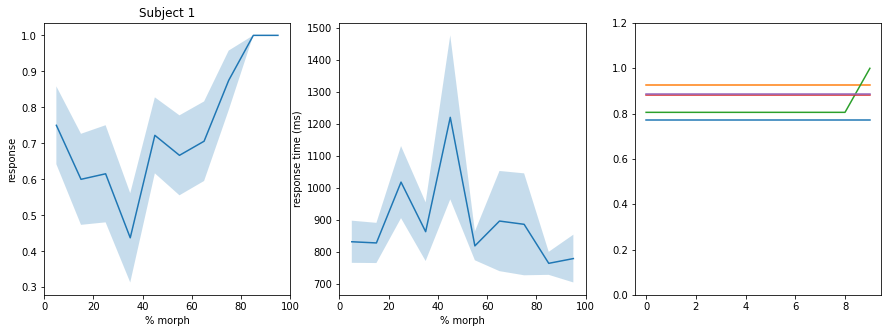

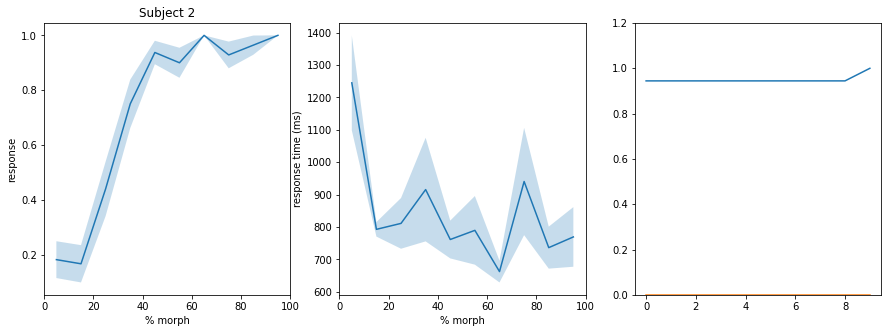

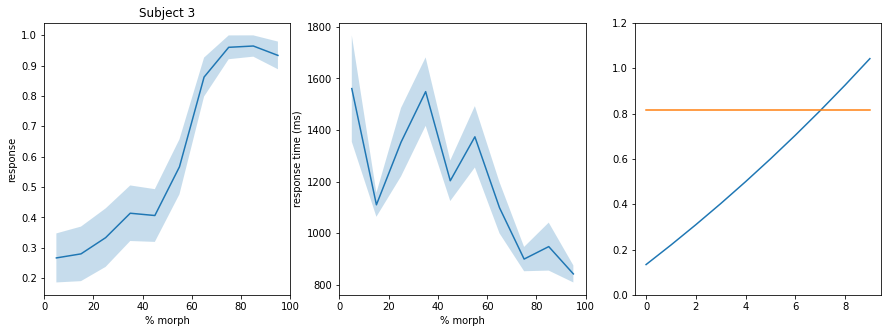

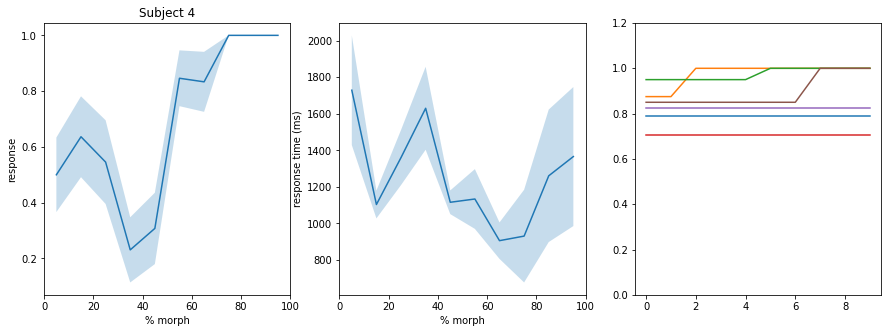

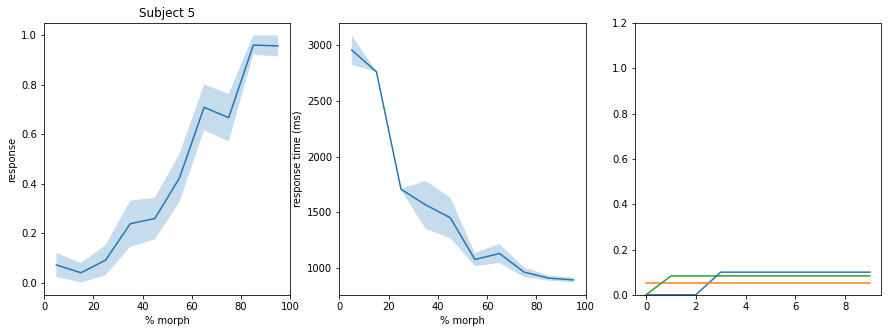

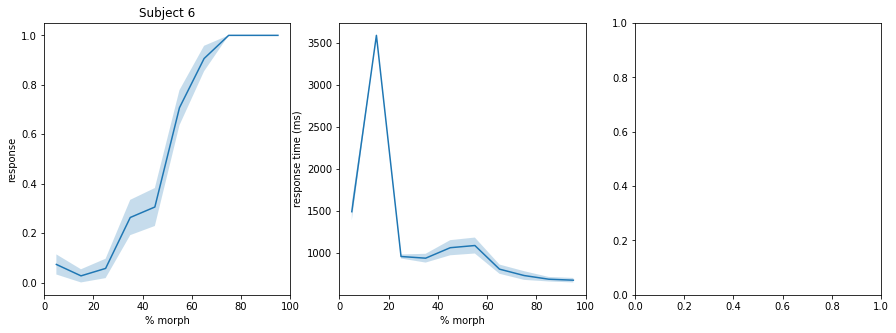

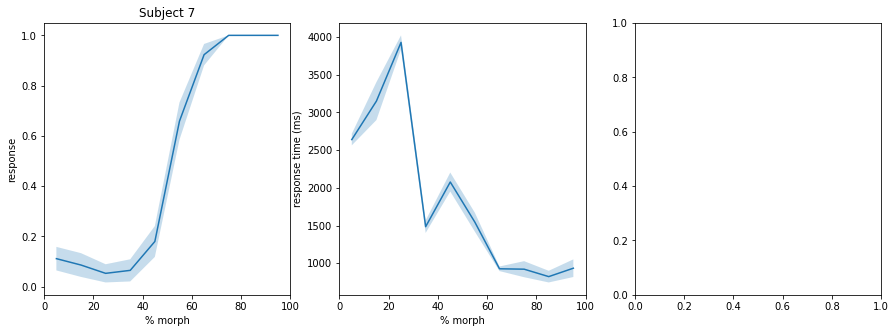

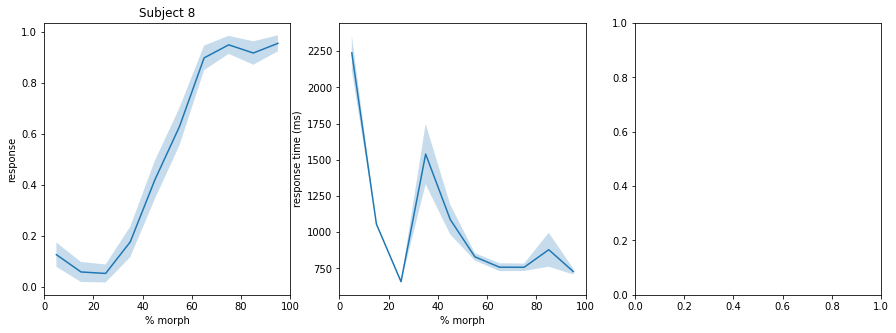

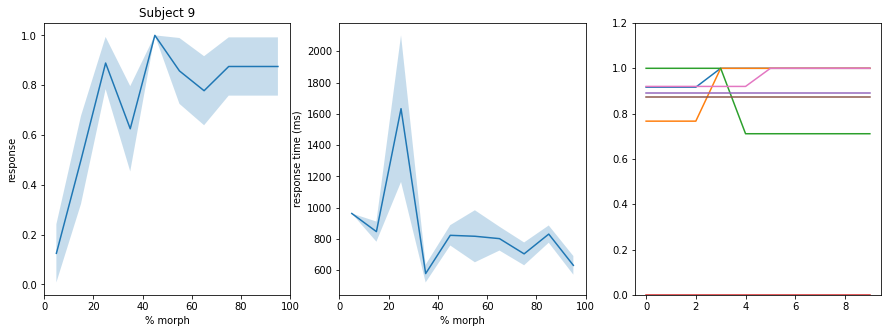

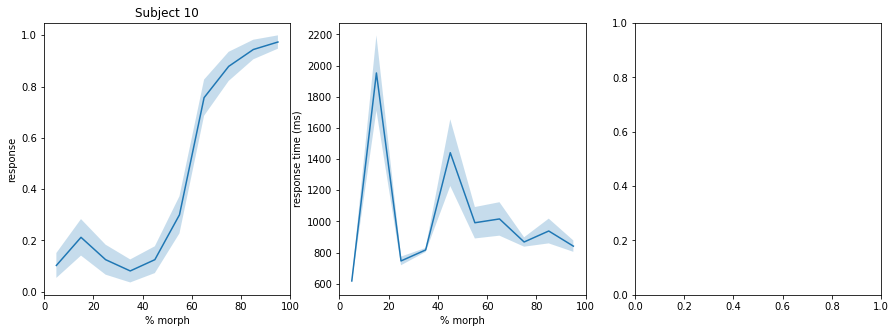

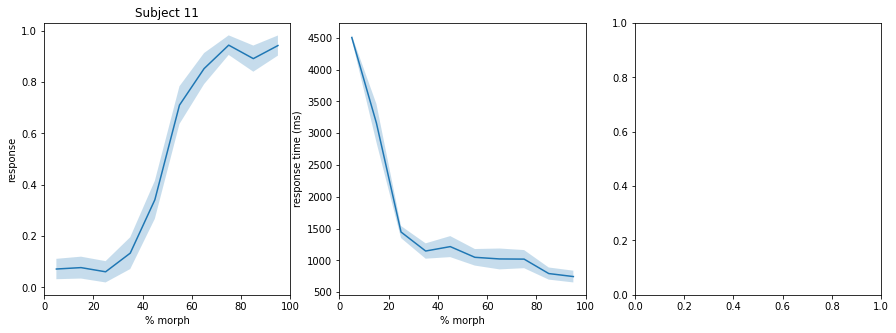

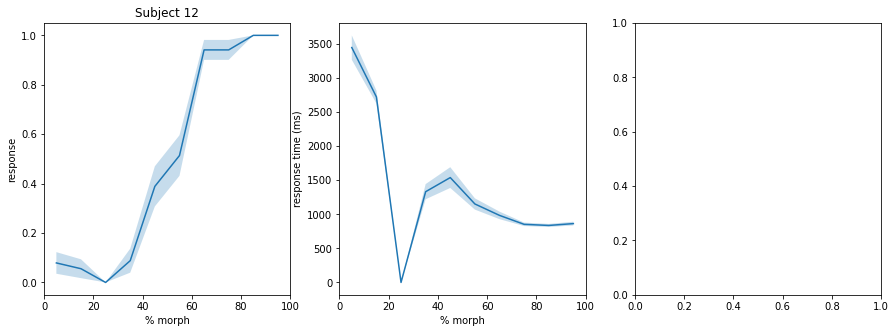

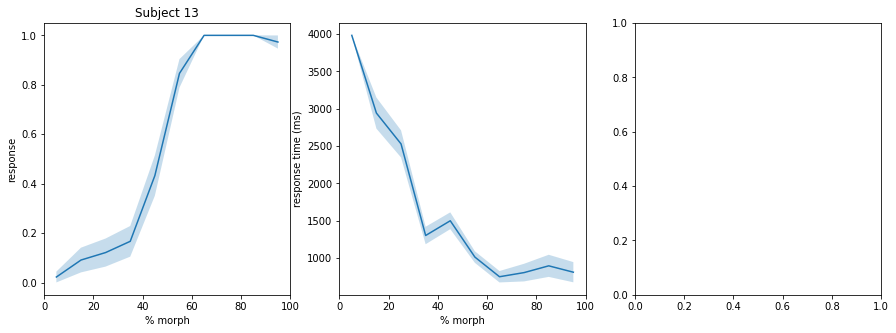

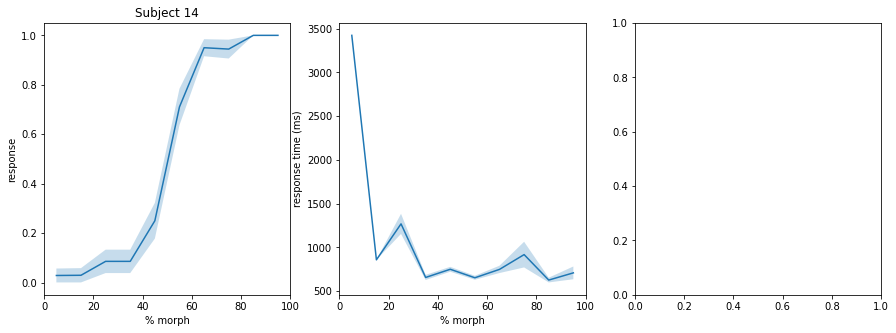

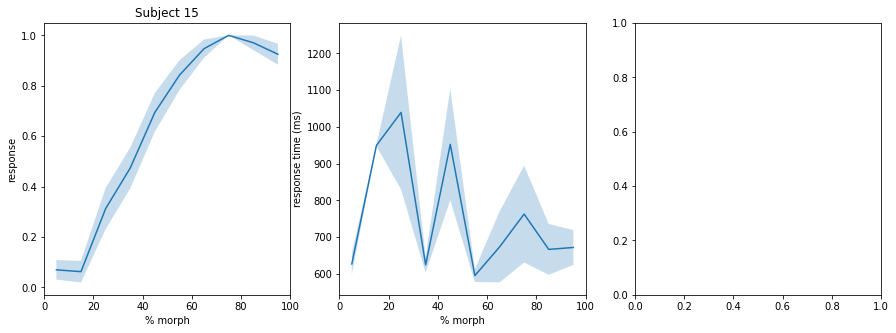

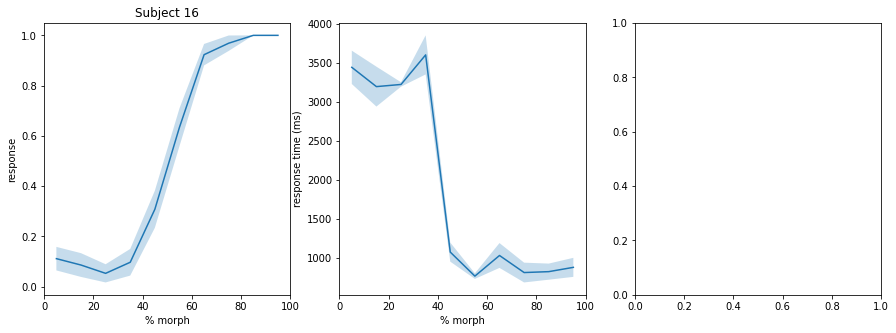

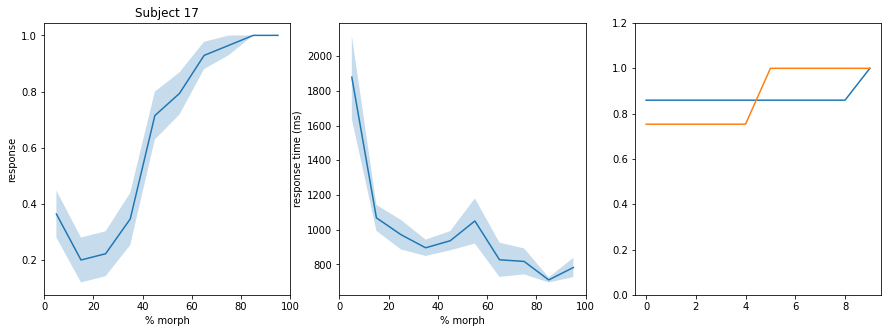

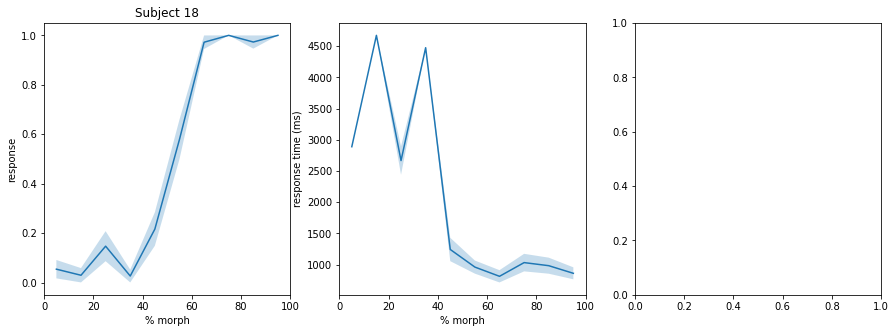

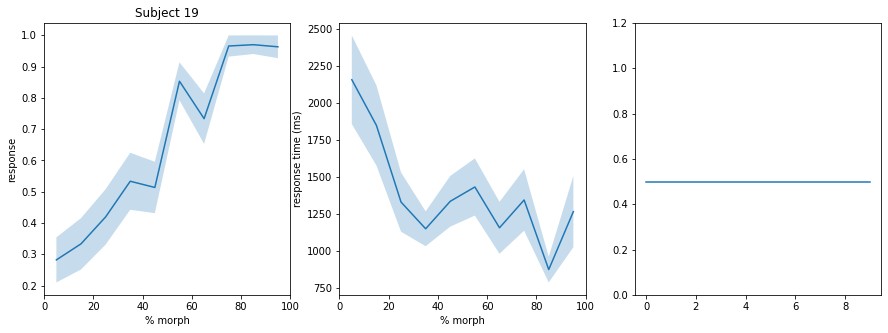

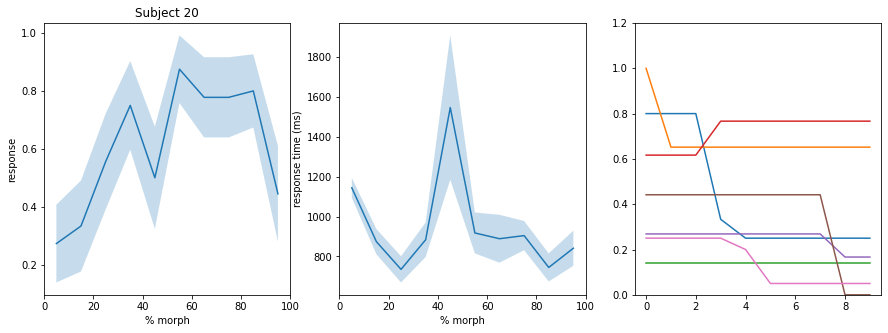

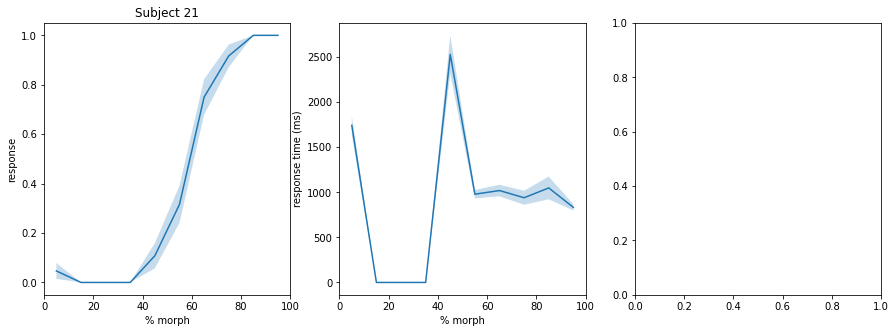

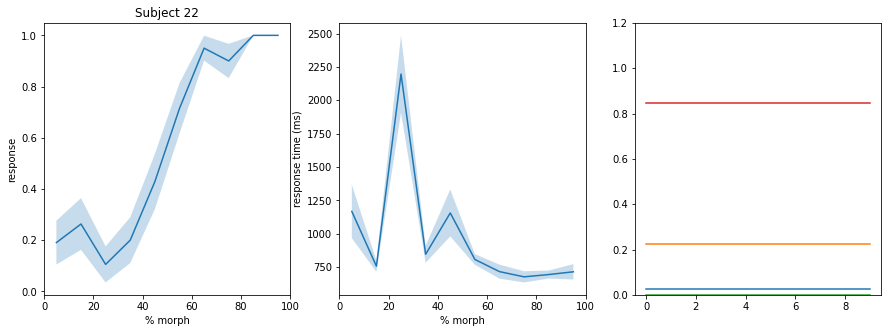

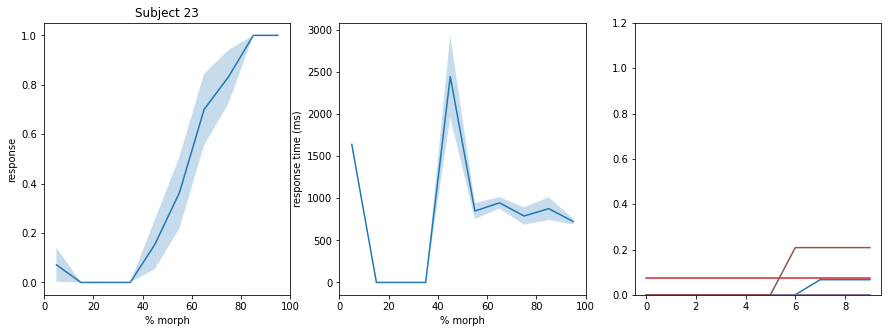

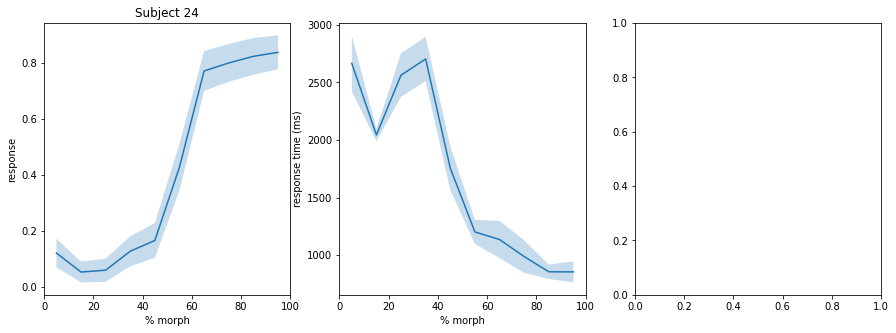

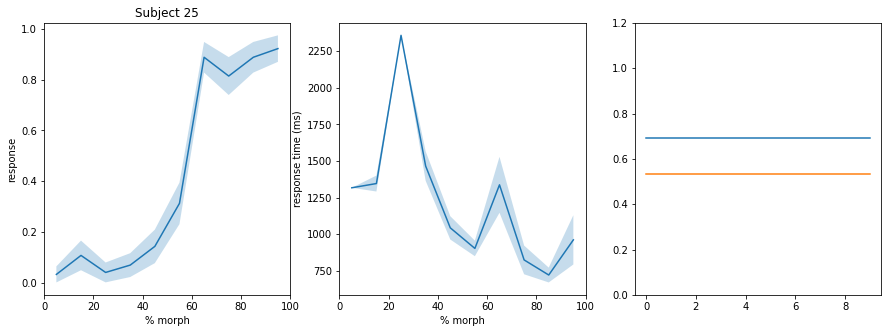

In [120]:
for i in range(1,26):
    results = view_results(i, do_plots=True, return_data=True)